# Run length encoding

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (that is, sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. This is most useful on data that contains many such runs. Consider, for example, simple graphic images such as icons, line drawings, and animations. It is not useful with files that don't have many runs as it could greatly increase the file size

https://en.wikipedia.org/wiki/Run-length_encoding

In [2]:
from PIL import Image
import numpy as np; print(np.__version__)

1.13.3


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 4 4 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


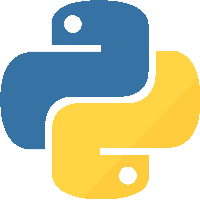

In [3]:
logo = Image\
        .open('python-logo.png')\
        .convert(mode='P', palette=Image.ADAPTIVE, colors=5)
data = np.array(logo).reshape(-1)
print(data[0:200])
logo

# Pure python

In [4]:
def rle_encode(sequence):
    """Run length encode array."""
    previous = sequence[0]
    count = 1
    out = []
    for element in sequence[1:]:
        if element == previous:
            count += 1
        else:
            out.append((count, previous))
            previous = element
            count = 1
    out.append((count, previous))
    return out

In [5]:
rle_encode('abbbccccccc')

[(1, 'a'), (3, 'b'), (7, 'c')]

In [6]:
def rle_decode(data):
    """Decode array with rle encoded data."""
    decoded = []
    for count, element in data:
        decoded.extend([element, ] * count)
    return decoded

In [7]:
''.join(rle_decode([(1, 'a'), (3, 'b'), (7, 'c')]))

'abbbccccccc'

In [8]:
import operator
timings = {}

def ratios(**new):
    assert len(new) == 1
    timings.update(**new)
    last = list(new.values())[0]
    print('\n'.join('%10s: %7.2f' % (name, t / last)
                    for name, t in sorted(timings.items(), key=operator.itemgetter(1))))

In [10]:
%%timeit
rle_encode(data)

5.05 ms ± 39.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
ratios(python=5110)

    python:    1.00


# Numpy

In [14]:
def rle_encode_numpy(sequence):
    diffs = np.concatenate(( np.array((True, )), np.diff(sequence)!=0))
    indices = np.concatenate((np.where(diffs)[0],np.array((sequence.size, ))))
    counts = np.diff(indices).astype('uint16')
    values = sequence[diffs].astype('uint8')
#     return counts, values
    return np.rec.fromarrays((counts, values),names=('count','value'))

In [ ]:
rle_encode_numpy(data)[0:5]

In [15]:
%%timeit 
rle_encode_numpy(data)

152 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
ratios(numpy=155)

# Cython

Cython is a superset of the Python programming language, designed to give C-like performance with code that is mostly written in Python.

https://en.wikipedia.org/wiki/Cython

In [ ]:
import cython; print(cython.__version__)
%load_ext cython

In [ ]:
%%cython -a
def rle_encode_cython(sequence):
    """Run length encode array."""
    previous = sequence[0]
    count = 1
    out = []
    for element in sequence[1:]:
        if element == previous:
            count += 1
        else:
            out.append((count, previous))
            previous = element
            count = 1
    out.append((count, previous))
    return out

In [ ]:
rle_encode_cython(data)[0:5]

In [ ]:
%%timeit 
rle_encode_cython(data)

In [ ]:
ratios(cython=3340)

In [ ]:
%%cython -a
cimport numpy as np
cimport cython

def rle_encode_cython_types(np.uint8_t [:] sequence not None):
    """Run length encode array."""
    cdef unsigned long i, n, count = 1, size = sequence.size
    cdef unsigned char element, previous = sequence[0]
    out = []
    for i in range(1,size):
        element = sequence[i]
        if element == previous:
            count += 1
        else:
            out.append((count, previous))
            previous = element
            count = 1
    out.append((count, previous))
    return out

In [ ]:
%%cython -a
cimport numpy as np
cimport cython

def rle_encode_cython_types(np.uint8_t [:] sequence not None):
    """Run length encode array."""
    cdef unsigned long i, n, count = 1, size = sequence.size
    cdef unsigned char element, previous = sequence[0]
    out = []
    for i in range(1,size):
        element = sequence[i]
        if element == previous:
            count += 1
        else:
            out.append((count, previous))
            previous = element
            count = 1
    out.append((count, previous))
    return out


    """Run length encode array."""
    cdef unsigned long i, n, count = 1, size = sequence.size
    cdef unsigned char previous = sequence[0]
    cdef unsigned char element
    
        cdef np.int16_t[:] result_buffer
    
    result = np.recarray((1000,), dtype=[('x', int), ('y', float), ('z', int)])
    result_buffer = result.view(np.int16)
    out = []
    for i in range(1,size):
        element = sequence[i]
        if element == previous:
            count += 1
        else:
            out.append((count, previous))
            previous = element
            count = 1
    out.append((count, previous))
    return out

In [ ]:
rle_encode_cython_types(data)[0:5]

In [ ]:
%%timeit 
rle_encode_cython_types(data)

In [ ]:
ratios(rle_encode_cython_types=1)

In [ ]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython

data_type = np.uint8
ctypedef np.uint8_t data_type_t
    
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.wraparound(False)

def rle_encode_cython_unsafe(data_type_t [:] sequence):
    """Run length encode array."""
    cdef unsigned long i, n=0, count = 1, size = 890
    cdef unsigned char element, previous = sequence[0]

    counts = np.empty(size,dtype=np.uint16)
    cdef np.uint16_t[:] counts_buffer = np.empty(size,dtype=np.uint16).view(np.uint16)
    values = np.empty(size,dtype=np.uint8)
    cdef np.uint8_t[:] values_buffer = np.empty(size,dtype=np.uint8).view(np.uint8)
    
    for i in range(1,size):
        element = sequence[i]
        if element == previous:
            count += 1
        else:
            n += 1
            counts_buffer[n] = count
            values_buffer[n] = previous
            previous = element
            count = 1
    n += 1        
    counts_buffer[n] = count
    values_buffer[n] = previous
    return (counts[:n], values[:n])
 

In [ ]:
counts, values = rle_encode_cython_unsafe(data)
print(counts[:5],values[:5])

In [ ]:
%%timeit 
rle_encode_cython_unsafe(data)

# Numba
Using [Just-in-time compilation](https://en.wikipedia.org/wiki/Just-in-time_compilation)

In [ ]:
import numba; print(numba.__version__)

In [ ]:
@numba.jit
def rle_encode_numba(sequence):
    """Run length encode array."""
    previous = sequence[0]
    count = 1
    out = []
    for element in sequence[1:]:
        if element == previous:
            count += 1
        else:
            out.append((count, previous))
            previous = element
            count = 1
    out.append((count, previous))
    return out

In [ ]:
rle_encode_numpy(data)[0:5]

In [ ]:
%%timeit 
rle_encode_numba(data)

In [ ]:
ratios(numba=1)